In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/FAKS/PO/Projekat

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/FAKS/PO/Projekat


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import joblib
import time

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline


np.random.seed(42)

%matplotlib inline

In [3]:
TEST_SIZE = 0.1

In [4]:
%run 'Params.ipynb'

In [5]:
df = pd.read_csv('urban_sound.csv')

In [6]:
X = copy.deepcopy(df.drop('class',axis=1))
y = copy.deepcopy(df['class'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

In [8]:
with open('X_test', 'w') as f:
    X_test.to_csv(f,index=False)
with open('y_test', 'w') as f:
    y_test.to_csv(f,index=False)

In [9]:
grouped_counter = y_train.groupby(by=y_train).count()
print(grouped_counter)
print(sum(grouped_counter))

class
air_conditioner     536
car_horn            282
children_playing    545
dog_bark            545
drilling            522
engine_idling       562
gun_shot            210
jackhammer          598
siren               552
street_music        539
Name: class, dtype: int64
4891


In [10]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
pca = PCA(n_components=2)
X_train_pca = pd.DataFrame(pca.fit_transform(X_train_norm),index=X_train.index)
df_train_pca = pd.concat([X_train_pca,y_train],axis=1)

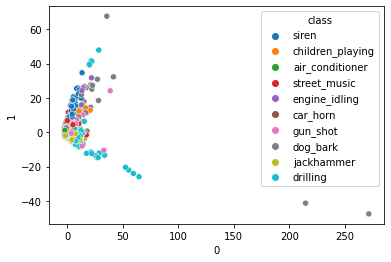

In [11]:
sns.scatterplot(data=df_train_pca,x=0,y=1,hue='class')

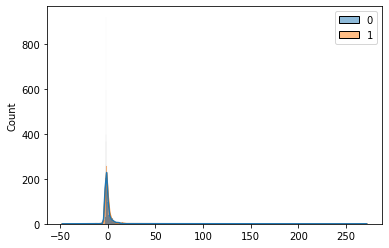

In [12]:
sns.histplot(df_train_pca,kde=True)

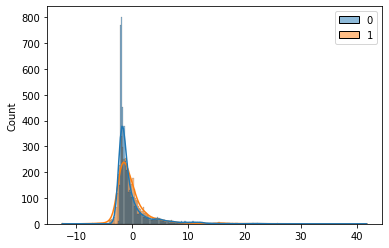

In [13]:
sns.histplot(df_train_pca[df_train_pca[0]<25],kde=True)

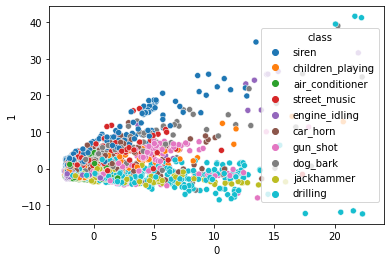

In [14]:
df_train_pca_without_outliers = df_train_pca[df_train_pca[0]<25]
sns.scatterplot(data=df_train_pca_without_outliers,x=0,y=1,hue='class')

In [15]:
print(df_train_pca_without_outliers.groupby(by='class').count()[1] / grouped_counter)
print(sum(df_train_pca_without_outliers.groupby(by='class').count()[1])/sum(grouped_counter))

class
air_conditioner     1.000000
car_horn            1.000000
children_playing    1.000000
dog_bark            0.988991
drilling            0.980843
engine_idling       1.000000
gun_shot            0.990476
jackhammer          1.000000
siren               1.000000
street_music        1.000000
dtype: float64
0.9963197710079739


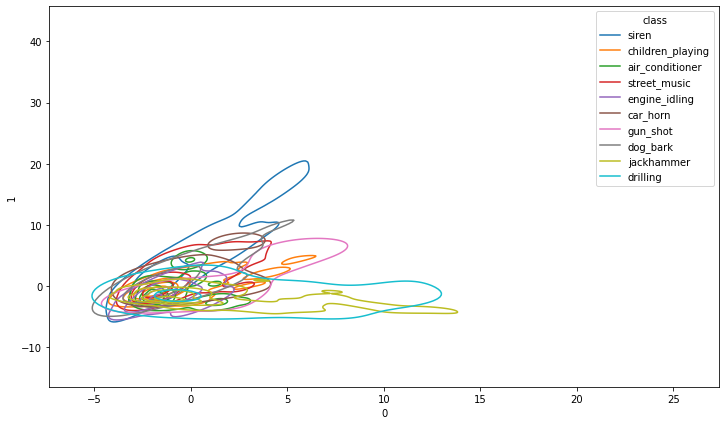

In [16]:
fig = plt.figure(figsize=(12,7))
g = sns.kdeplot(
    data=df_train_pca_without_outliers, x=0, y=1, hue="class",
    levels=5, thresh=0.05
);

In [17]:
df_train_without_outliers = df.loc[df_train_pca_without_outliers.index]
X_train = X_train.loc[df_train_pca_without_outliers.index]
y_train = y_train.loc[df_train_pca_without_outliers.index]

## Neural network classifier

In [18]:
pipe_nn = Pipeline(steps=[('scaler',StandardScaler()),('mlp', MLPClassifier())]) 

In [19]:
nn_hyperparameters = get_nn_hyperparams()

In [20]:
nn_rgrid = RandomizedSearchCV(pipe_nn,cv=10, param_distributions=nn_hyperparameters,scoring='f1_micro', 
            n_jobs=-1,n_iter=10)

In [21]:
start_time = time.time()
nn_rgrid.fit(X_train,y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1126.510745048523 seconds ---


In [22]:
joblib.dump(nn_rgrid.best_estimator_, 'nn.pkl')

['nn.pkl']

## Logistic regression

In [23]:
lgr_hyperparameters = get_lgr_hyperparams()

In [24]:
pipe_lgr = Pipeline(steps=[('scaler',StandardScaler()),('lgr', LogisticRegression())]) 

In [25]:
lgr_rgrid = GridSearchCV(pipe_lgr,cv=10, 
            param_grid=lgr_hyperparameters,scoring='f1_micro', n_jobs=-1)

In [26]:
start_time = time.time()
lgr_rgrid.fit(X_train,y_train)
print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  F

--- 1305.4389097690582 seconds ---


In [27]:
joblib.dump(lgr_rgrid.best_estimator_, 'lgr.pkl')

['lgr.pkl']

## K nearest neighbors

In [28]:
knn_hyperparameters = get_knn_hyperparams(df)

In [29]:
pipe_knn = Pipeline(steps=[('scaler',StandardScaler()),('knn', KNeighborsClassifier())]) 

In [30]:
knn_rgrid = GridSearchCV(pipe_knn,cv=10, param_grid=knn_hyperparameters,
                            scoring='f1_micro', n_jobs=-1)

In [31]:
start_time = time.time()
knn_rgrid.fit(X_train,y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 19.95880389213562 seconds ---


In [32]:
joblib.dump(knn_rgrid.best_estimator_, 'knn.pkl')

['knn.pkl']

## Neural network classifier with PCA

In [33]:
pipe_nn_pca = Pipeline(steps=[('scaler',StandardScaler()),('pca',PCA()),('mlp', MLPClassifier())]) 

In [34]:
nn_pca_hyperparameters = get_nn_pca_hyperparams()

In [35]:
nn_pca_rgrid = RandomizedSearchCV(pipe_nn_pca,cv=10, param_distributions=nn_pca_hyperparameters,scoring='f1_micro', n_jobs=-1)

In [36]:
start_time = time.time()
nn_pca_rgrid.fit(X_train,y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1959.6646103858948 seconds ---


In [37]:
joblib.dump(nn_pca_rgrid.best_estimator_, 'nn_pca.pkl')

['nn_pca.pkl']

## Logistic regression with PCA

In [38]:
lgr_pca_hyperparameters = get_lgr_pca_hyperparams()

In [39]:
pipe_lgr_pca = Pipeline(steps=[('scaler',StandardScaler()),('pca',PCA()),('lgr', LogisticRegression())]) 

In [40]:
lgr_pca_rgrid = GridSearchCV(pipe_lgr_pca,cv=10, param_grid=lgr_pca_hyperparameters,scoring='f1_micro', n_jobs=-1)

In [41]:
start_time = time.time()
lgr_pca_rgrid.fit(X_train,y_train)
print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  F

--- 547.3056013584137 seconds ---


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [42]:
joblib.dump(lgr_pca_rgrid.best_estimator_, 'lgr_pca.pkl')

['lgr_pca.pkl']

## K nearest neighbors with PCA

In [43]:
knn_pca_hyperparameters = get_knn_pca_hyperparams(df)

In [44]:
pipe_knn_pca = Pipeline(steps=[('scaler',StandardScaler()),('pca',PCA()),('knn', KNeighborsClassifier())]) 

In [45]:
knn_pca_rgrid = GridSearchCV(pipe_knn_pca,cv=10, param_grid=knn_pca_hyperparameters,scoring='f1_micro', n_jobs=-1)

In [46]:
start_time = time.time()
knn_pca_rgrid.fit(X_train,y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 33.39593744277954 seconds ---


In [47]:
joblib.dump(knn_pca_rgrid.best_estimator_, 'knn_pca.pkl')

['knn_pca.pkl']

# Predictions

In [48]:
print(nn_rgrid.best_estimator_)
print(nn_rgrid.best_score_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(batch_size=128, hidden_layer_sizes=(128, 64),
                               learning_rate='adaptive', max_iter=500))])
0.9228431009526373


In [49]:
nn_rgrid.score(X_test,y_test)

0.9080882352941178

In [50]:
print(lgr_rgrid.best_estimator_)
print(lgr_rgrid.best_score_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lgr', LogisticRegression(solver='newton-cg'))])
0.7609309253711245


In [51]:
lgr_rgrid.score(X_test,y_test)

0.744485294117647

In [52]:
print(knn_rgrid.best_estimator_)
print(knn_rgrid.best_score_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=1))])
0.9343298717473996


In [53]:
knn_rgrid.score(X_test,y_test)

0.9209558823529411

In [54]:
print(nn_pca_rgrid.best_estimator_)
print(nn_pca_rgrid.best_score_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('mlp',
                 MLPClassifier(batch_size=128, hidden_layer_sizes=(128, 64),
                               learning_rate_init=0.01, max_iter=300))])
0.9049836738815766


In [55]:
nn_pca_rgrid.score(X_test,y_test)

0.8786764705882353

In [56]:
print(lgr_pca_rgrid.best_estimator_)
print(lgr_pca_rgrid.best_score_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('lgr', LogisticRegression(C=0.5))])
0.687255108223651


In [57]:
lgr_pca_rgrid.score(X_test,y_test)

0.65625

In [58]:
print(knn_pca_rgrid.best_estimator_)
print(knn_pca_rgrid.best_score_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('knn',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=1))])
0.9201711717776954


In [59]:
knn_pca_rgrid.score(X_test,y_test)

0.9209558823529411